In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import maxwell

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

import algorithms as a
import force_functions as f

In [2]:
np.random.seed(13)

In [3]:
N = 125
L = (128/0.4)**(1/3)
lam = 0.1931833275037836
lc = 1.5
T = 0.4
(N+3)/(L**3)

0.40000000000000013

In [4]:
def init(N, L, lattice_constant):
    
    positions = list(np.arange(-L/2., L/2., lattice_constant))
    r0 = np.array(np.meshgrid(positions, positions, positions)).T.reshape(-1,3)
    #r0 = r0[np.random.randint(len(r0), size=N)]
    p0 = ((-1)**(np.random.randint(2, size=(128,3)))) * maxwell.rvs(loc=0, scale=1.5, size=(128,3)) / np.sqrt(T)
    
    return r0, p0

In [5]:
def calc_energy(r, p, sigma, periodic=None):
    if periodic is None:
        periodic = {'PBC': False,
                    'box_size': 0,
                    'closed': False}

    idx = np.arange(len(r))
    pairs = np.meshgrid(idx, idx)
    separations = r[pairs[0]] - r[pairs[1]]

    if periodic['PBC']:
        separations[np.where(separations > periodic['box_size'] / 2.)] -= periodic['box_size']
        separations[np.where(separations < -periodic['box_size'] / 2.)] += periodic['box_size']

    distances = np.triu(np.linalg.norm(separations, axis=-1))

    V = (4 * np.power(sigma / distances, 12) - 4 * np.power(sigma / distances, 6))
    V[np.isnan(V)] = 0.
    V = V.sum()
    
    T = .5 * np.linalg.norm(p)**2
    
    return V + T

In [81]:
r0, p0 = init(N=N, L=L, lattice_constant=lc) #125 particles
r0 = np.concatenate((r0, np.array([[3.1, 2.9, -2.9],[1.8, -1.8, 1.8], [0.3, 0.3, -0.3]])), axis=0) #128 particles

In [82]:
dd = np.empty(1)

idx = np.arange(len(r0))
pairs = np.meshgrid(idx, idx)
separations = r0[pairs[0]] - r0[pairs[1]]
distances = np.triu(np.linalg.norm(separations, axis=-1))
dd = np.append(dd, (distances[np.where(distances > 0.)]))
dd.min()

0.6324555320336759

In [83]:
dt1 = 0.0005
dt2 = dt1*2
dt3 = dt1*4
t_max1 = 10**3 * dt1
t_max2 = 10**3 * dt2
t_max3 = 10**3 * dt3

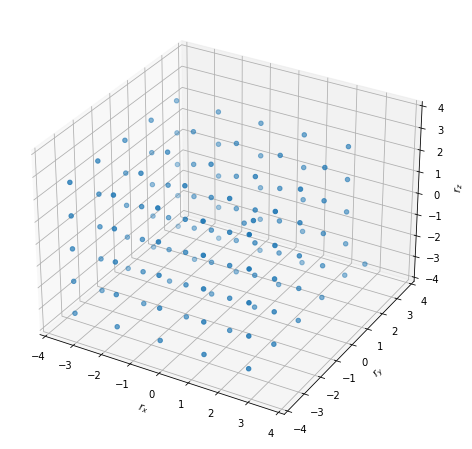

In [84]:
fig0 = plt.figure(figsize=(12,8));
ax0 = fig0.add_subplot(111, projection='3d')
ax0.scatter(r0[:,0], r0[:,1], r0[:,2])
ax0.set_xlabel(r'$r_x$')
ax0.set_ylabel(r'$r_y$')
ax0.set_zlabel(r'$r_z$')
ax0.set_xlim(-L/1.7,L/1.7)
ax0.set_ylim(-L/1.7,L/1.7)
ax0.set_zlim(-L/1.7,L/1.7)
#plt.savefig('./figures/init_pos.png', dpi=300, bbox_inches='tight')
plt.show()

In [85]:
R1, P1, t1 = a.velocity_verlet_Ndim(r0.copy(), p0.copy(), t_max1, dt1, f.LJ_force,periodic={'PBC': True, 'box_size': L, 'closed': False})
R2, P2, t2 = a.velocity_verlet_Ndim(r0.copy(), p0.copy(), t_max2, dt2, f.LJ_force,periodic={'PBC': True, 'box_size': L, 'closed': False})
R3, P3, t3 = a.velocity_verlet_Ndim(r0.copy(), p0.copy(), t_max3, dt3, f.LJ_force,periodic={'PBC': True, 'box_size': L, 'closed': False})

  0%|          | 0/999 [00:00<?, ?it/s]C:\Users\ACER\Documents\UNI\Master\MD\Exam\molecular_simulations-emil\force_functions.py:173: RuntimeWarning: divide by zero encountered in true_divide
  f = (48 * np.power(sigma, 12) / np.power(distances, 13) - 24 * np.power(sigma, 6) / np.power(distances, 7)) / distances
C:\Users\ACER\Documents\UNI\Master\MD\Exam\molecular_simulations-emil\force_functions.py:173: RuntimeWarning: invalid value encountered in subtract
  f = (48 * np.power(sigma, 12) / np.power(distances, 13) - 24 * np.power(sigma, 6) / np.power(distances, 7)) / distances
100%|██████████| 999/999 [00:06<00:00, 149.33it/s]


In [86]:
E1 = np.zeros(len(t1))
E2 = np.zeros(len(t2))
E3 = np.zeros(len(t3))
for i in tqdm(range(len(t3))):
    E1[i] = calc_energy(R1[i], P1[i], sigma=1, periodic={'PBC': True, 'box_size': L, 'closed': False})
    E2[i] = calc_energy(R2[i], P2[i], sigma=1, periodic={'PBC': True, 'box_size': L, 'closed': False})
    E3[i] = calc_energy(R3[i], P3[i], sigma=1, periodic={'PBC': True, 'box_size': L, 'closed': False})

  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-5-c07f12e42591>:17: RuntimeWarning: divide by zero encountered in true_divide
  V = (4 * np.power(sigma / distances, 12) - 4 * np.power(sigma / distances, 6))
<ipython-input-5-c07f12e42591>:17: RuntimeWarning: invalid value encountered in subtract
  V = (4 * np.power(sigma / distances, 12) - 4 * np.power(sigma / distances, 6))
100%|██████████| 1000/1000 [00:08<00:00, 115.78it/s]


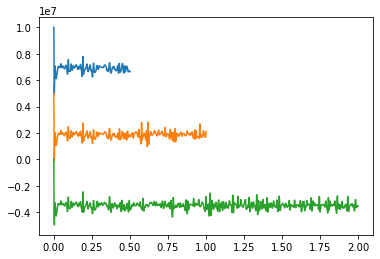

In [87]:
plt.plot(t1, (E1-E1[0])*(dt1**-2)+10000000)
plt.plot(t2, (E2-E2[0])*(dt2**-2)+5000000)
plt.plot(t3, (E3-E3[0])*(dt3**-2))

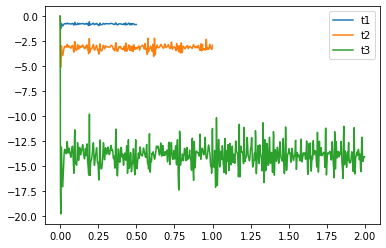

In [88]:
plt.plot(t1[:], (E1-E1[0])[:], label='t1')
plt.plot(t2, (E2-E2[0]), label='t2')
plt.plot(t3, (E3-E3[0]), label='t3')
plt.legend()
plt.show()

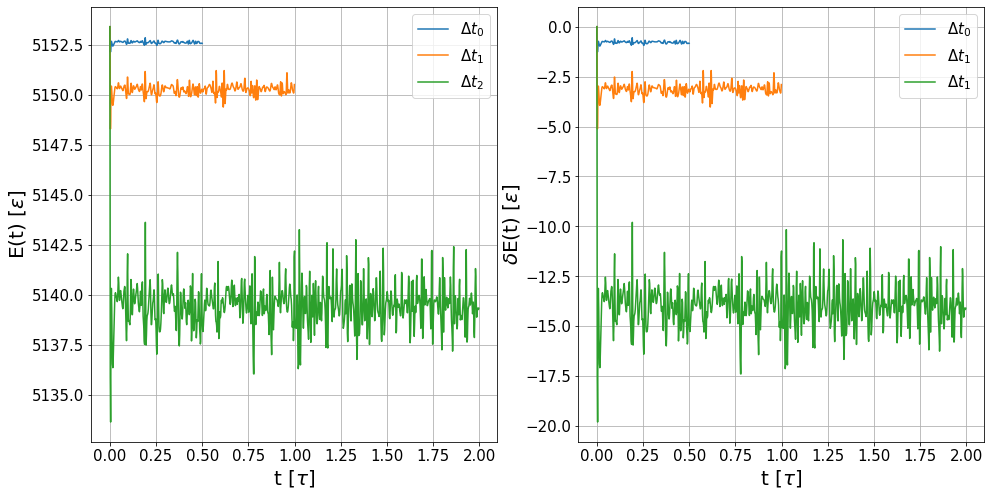

In [89]:
fig1, ax1 = plt.subplots(ncols=2, nrows=1, figsize=(16,8))
ax1[0].plot(t1, E1, label='$\Delta t_0$')
ax1[0].set_xlabel(r't [$\tau$]', fontsize=20)
ax1[0].set_ylabel(r'E(t) [$\epsilon$]', fontsize=20)
ax1[0].tick_params(axis='x', labelsize=15)
ax1[0].tick_params(axis='y', labelsize=15)
ax1[0].legend(prop={'size': 20})

ax1[1].plot(t1, E1-E1[0], label='$\Delta t_0$')
ax1[1].set_xlabel(r't [$\tau$]', fontsize=20)
ax1[1].set_ylabel(r'$\delta$E(t) [$\epsilon$]', fontsize=20)
ax1[1].tick_params(axis='x', labelsize=15)
ax1[1].tick_params(axis='y', labelsize=15)

ax1[0].plot(t2, E2, label='$\Delta t_1$')
ax1[0].set_xlabel(r't [$\tau$]', fontsize=20)
ax1[0].set_ylabel(r'E(t) [$\epsilon$]', fontsize=20)
ax1[0].tick_params(axis='x', labelsize=15)
ax1[0].tick_params(axis='y', labelsize=15)
ax1[0].legend(prop={'size': 20})

ax1[1].plot(t2, E2-E2[0], label='$\Delta t_1$')
ax1[1].set_xlabel(r't [$\tau$]', fontsize=20)
ax1[1].set_ylabel(r'$\delta$E(t) [$\epsilon$]', fontsize=20)
ax1[1].tick_params(axis='x', labelsize=15)
ax1[1].tick_params(axis='y', labelsize=15)

ax1[0].plot(t3, E3, label='$\Delta t_2$')
ax1[0].set_xlabel(r't [$\tau$]', fontsize=20)
ax1[0].set_ylabel(r'E(t) [$\epsilon$]', fontsize=20)
ax1[0].tick_params(axis='x', labelsize=15)
ax1[0].tick_params(axis='y', labelsize=15)
ax1[0].legend(prop={'size': 20})

ax1[1].plot(t3, E3-E3[0], label='$\Delta t_2$')
ax1[1].set_xlabel(r't [$\tau$]', fontsize=20)
ax1[1].set_ylabel(r'$\delta$E(t) [$\epsilon$]', fontsize=20)
ax1[1].tick_params(axis='x', labelsize=15)
ax1[1].tick_params(axis='y', labelsize=15)


for i in range(2):
        ax1[i].legend(prop={'size': 15})
        ax1[i].grid(True)

plt.savefig('./exam_figures/1a1.png', dpi=600, bbox_inches='tight')

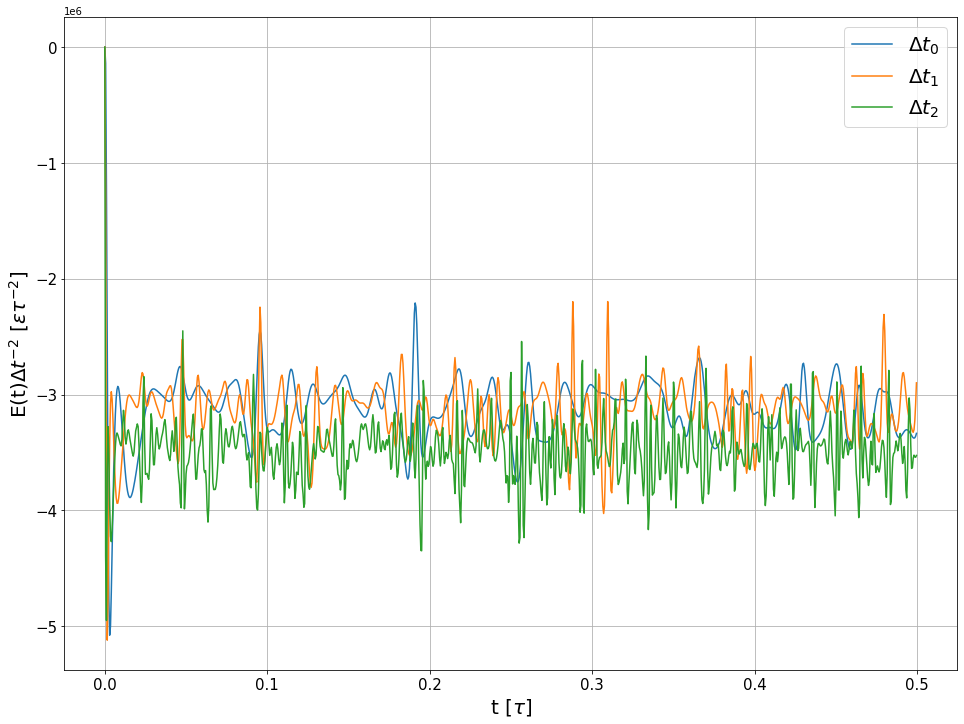

In [90]:
fig2, ax2 = plt.subplots(ncols=1, nrows=1, figsize=(16,12))
ax2.plot(t1, (E1-E1[0])*dt1**-2, label='$\Delta t_0$')
ax2.set_xlabel(r't [$\tau$]', fontsize=20)
ax2.set_ylabel(r'E(t)$\Delta t^{-2}$ [$\epsilon \tau^{-2}$]', fontsize=20)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax2.legend(prop={'size': 20})

ax2.plot(t1, (E2-E2[0])*dt2**-2, label='$\Delta t_1$')
ax2.set_xlabel(r't [$\tau$]', fontsize=20)
ax2.set_ylabel(r'E(t)$\Delta t^{-2}$ [$\epsilon \tau^{-2}$]', fontsize=20)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax2.legend(prop={'size': 20})

ax2.plot(t1, (E3-E3[0])*dt3**-2, label='$\Delta t_2$')
ax2.set_xlabel(r't [$\tau$]', fontsize=20)
ax2.set_ylabel(r'E(t)$\Delta t^{-2}$ [$\epsilon \tau^{-2}$]', fontsize=20)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax2.legend(prop={'size': 20})

ax2.grid(True)

plt.savefig('./exam_figures/1a2.png', dpi=600, bbox_inches='tight')

In [91]:
R, P, t = a.velocity_verlet_Ndim(r0.copy(), p0.copy(), t_max1*5, dt1, f.LJ_force,periodic={'PBC': True, 'box_size': L, 'closed': False})

  0%|          | 0/4999 [00:00<?, ?it/s]C:\Users\ACER\Documents\UNI\Master\MD\Exam\molecular_simulations-emil\force_functions.py:173: RuntimeWarning: divide by zero encountered in true_divide
  f = (48 * np.power(sigma, 12) / np.power(distances, 13) - 24 * np.power(sigma, 6) / np.power(distances, 7)) / distances
C:\Users\ACER\Documents\UNI\Master\MD\Exam\molecular_simulations-emil\force_functions.py:173: RuntimeWarning: invalid value encountered in subtract
  f = (48 * np.power(sigma, 12) / np.power(distances, 13) - 24 * np.power(sigma, 6) / np.power(distances, 7)) / distances
100%|██████████| 4999/4999 [00:38<00:00, 131.06it/s]


In [ ]:
E = np.zeros(len(t))
for i in tqdm(range(len(t))):
    E[i] = calc_energy(R[i], P[i], sigma=1, periodic={'PBC': True, 'box_size': L, 'closed': False})

  0%|          | 0/5000 [00:00<?, ?it/s]<ipython-input-5-c07f12e42591>:17: RuntimeWarning: divide by zero encountered in true_divide
  V = (4 * np.power(sigma / distances, 12) - 4 * np.power(sigma / distances, 6))
<ipython-input-5-c07f12e42591>:17: RuntimeWarning: invalid value encountered in subtract
  V = (4 * np.power(sigma / distances, 12) - 4 * np.power(sigma / distances, 6))
 51%|█████▏    | 2565/5000 [00:07<00:06, 376.37it/s]

In [ ]:
P_total = np.sum(P, axis=1)

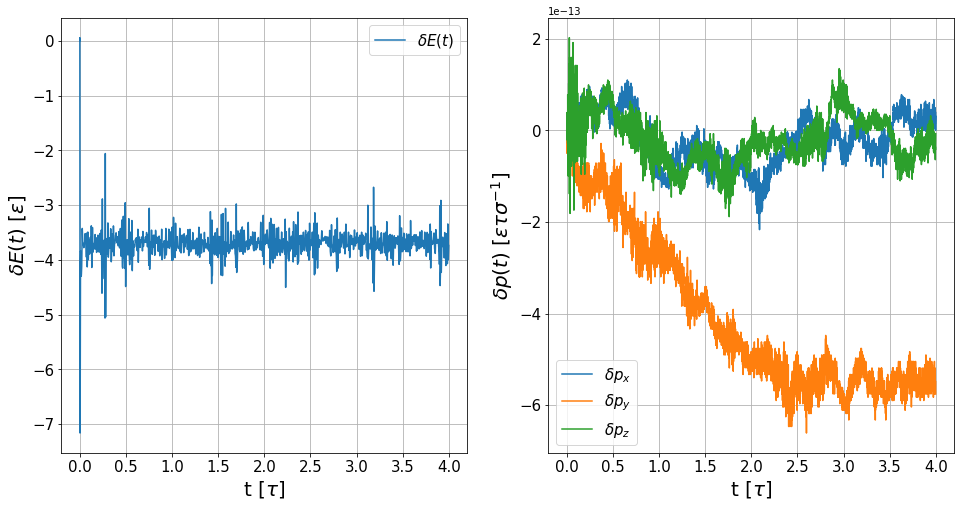

In [69]:
fig3, ax3 = plt.subplots(ncols=2, nrows=1, figsize=(16,8))
ax3[0].plot(t, (E - E[0]), label='$\delta E(t)$')
ax3[0].set_xlabel(r't [$\tau$]', fontsize=20)
ax3[0].set_ylabel(r'$\delta E(t)$ [$\epsilon$]', fontsize=20)
ax3[0].tick_params(axis='x', labelsize=15)
ax3[0].tick_params(axis='y', labelsize=15)
ax3[0].legend(prop={'size': 20})

ax3[1].plot(t, P_total[:,0]-P_total[0,0], label='$\delta p_x$')
ax3[1].set_xlabel(r't [$\tau$]', fontsize=20)
ax3[1].set_ylabel(r'$\delta p(t)$ [$\epsilon \tau \sigma^{-1}$]', fontsize=20)
ax3[1].tick_params(axis='x', labelsize=15)
ax3[1].tick_params(axis='y', labelsize=15)
ax3[1].legend(prop={'size': 20})

ax3[1].plot(t, P_total[:,1]-P_total[0,1], label='$\delta p_y$')
ax3[1].set_xlabel(r't [$\tau$]', fontsize=20)
ax3[1].set_ylabel(r'$\delta p(t)$ [$\epsilon \tau \sigma^{-1}$]', fontsize=20)
ax3[1].tick_params(axis='x', labelsize=15)
ax3[1].tick_params(axis='y', labelsize=15)
ax3[1].legend(prop={'size': 20})

ax3[1].plot(t, P_total[:,2]-P_total[0,2], label='$\delta p_z$')
ax3[1].set_xlabel(r't [$\tau$]', fontsize=20)
ax3[1].set_ylabel(r'$\delta p(t)$ [$\epsilon \tau \sigma^{-1}$]', fontsize=20)
ax3[1].tick_params(axis='x', labelsize=15)
ax3[1].tick_params(axis='y', labelsize=15)
ax3[1].legend(prop={'size': 20})

for i in range(2):
        ax3[i].legend(prop={'size': 15})
        ax3[i].grid(True)
        
plt.savefig('./exam_figures/1b1.png', dpi=600, bbox_inches='tight')

In [44]:
rmsd = np.sqrt(np.mean((E-E[0])**2)/np.mean(E)**2)
rmsd

0.0010363359869593235

In [45]:
absdev = np.sqrt(np.mean(np.linalg.norm(P-P[0], axis = (1,2))))
absdev

11.464877743773648

4.9615825131397745e-06